# Image registration demo

In this notebook, we show an example of two images recorded by a camera with an interval of six months, during which time the camera position has changed and the focus setting have also led to some blur. The goal is to correct for the camera movement so that data taken from the images can be directly compared.

We start by import the local module that contains two classes; The **EEC_aligner** class registers images using the Enhanced Correlation Coefficient (ECC) algorithm, while the **keypoint_aligner** class registers images using local features shared between objects. The ECC_aligner has flexibility in which motion model is fitted, while the keypoint aligner focusses on homographic models that are suited to larger camera movements, but may be overkill for simple use cases.

We start by identifying two images to align as template and test. (In the deployment application, the template image serves as a reference standard for many test images, all of which need to have a constant alignment).


In [4]:
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd()))
import registration as register

template_file = "./img/2016-04-29 10_31_56.jpg"
test_file = "./img/2016-10-20 08_51_00.jpg"

Load grayscale versions and show images next to each other to illustrate the problem:

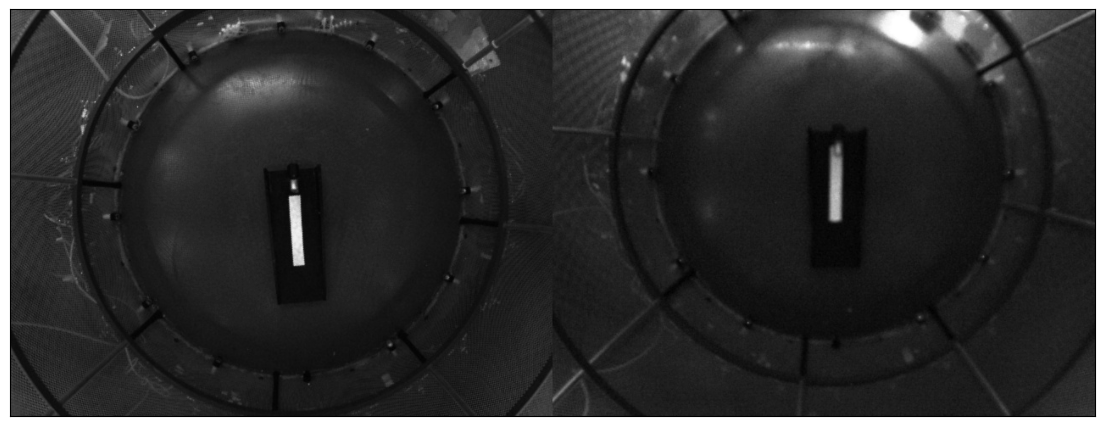

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

template_img = cv2.imread( template_file, cv2.IMREAD_GRAYSCALE)
test_img = cv2.imread( test_file, cv2.IMREAD_GRAYSCALE)

def show_combined_img(img_A, img_B, cmap:str='gray'):

    img_combined = np.concatenate((img_A, img_B), axis=1)

    fig, ax = plt.subplots(1,1, **{'figsize':(14,7)})
    ax.imshow(img_combined, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

show_combined_img(template_img, test_img)
plt.show()

## Intensity based method using Enhanced Correlation Coefficient 

We create an instance of the ecc_aligner class and define the algorithm settings. Increasing the number of iterations, or reducing the termination criteria will take longer, but may improve the fit in some difficult cases.

In this case, we'll use 

In [6]:
ecc_settings = dict(
    warp_mode = cv2.MOTION_EUCLIDEAN, 
    n_iterations = 6000, 
    termination_eps = 1e-9
)

ecc = register.ecc_aligner(template_img=template_img, **ecc_settings)

ecc.estimate(test_img)

print(ecc.warp_matrix)
print(f"{test_file}: correlation = {ecc.cc}")

[[  0.9915212   -0.12994534  34.4659    ]
 [  0.12994534   0.9915212  -88.05437   ]]
./img/2016-10-20 08_51_00.jpg: correlation = 0.4992158655255622


If we apply the correction, we can see that the registration signficantly improves the alignment between the two images.

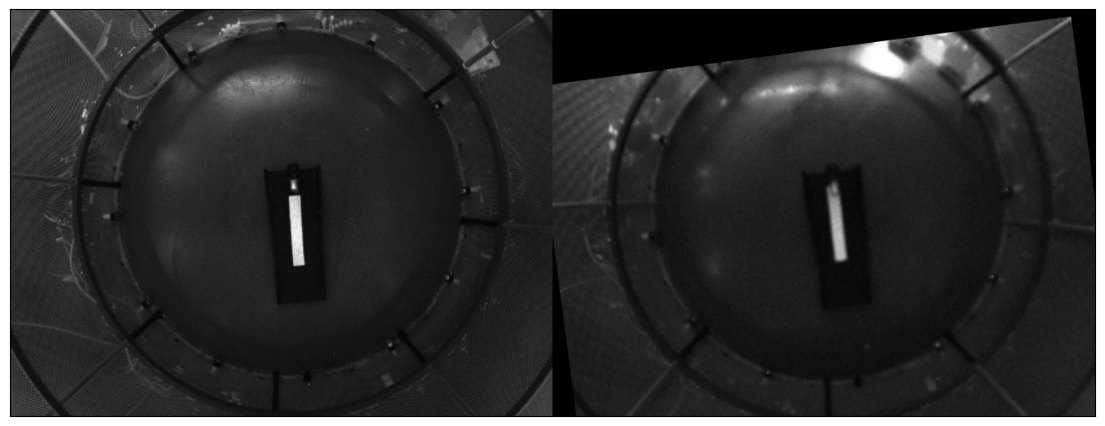

In [7]:
ecc_aligned = ecc.apply_correction(test_img)

show_combined_img(template_img, ecc_aligned)
plt.show()

The final step (not shown here) is to save the affine transform matrix as a text file for later use. Having the tranformation allows us to correct for camera movement in all frames of a video or align the positions of tracked markers.

## Keypoint based alignment

The keypoint class is specifically designed for homographic transforms, which aren't usually necessary for the camera motion in this application. The added degrees of freedom leads to poor performance when compared to the Euclidean motion model used by the ECC aligner. However the code is shown to illustrate the use of the class, in case the camera movements become more extreme.

Note that the visualization is done in OpenCV, which doesn't always play nicely with the Jupyter notebook format and so the keypoints shown here are from a saved version of the output:

In [8]:
kpt = register.keypoint_aligner(template_img=template_img)

matches, test_kpts = kpt.match_images(test_img, keepPercent=10)
# kpt.show_matches(test_img, test_kpts, matches)

<img src="./img/MatchedKeypoints_screenshot_25.03.2023.png">

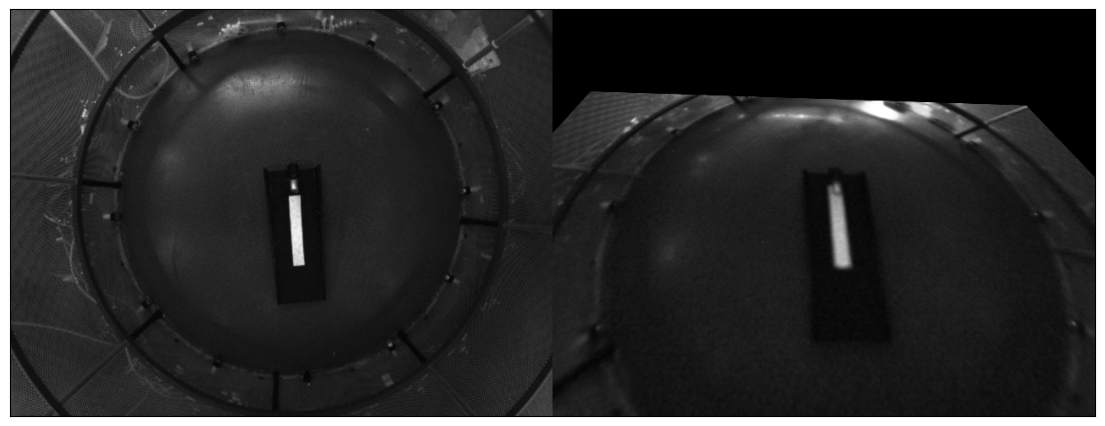

In [9]:
kpt_homography = kpt.get_homography_matrix(matches, test_kpts)
kpt_aligned = kpt.apply_correction(test_img, kpt_homography)

show_combined_img(template_img, kpt_aligned)
plt.show()